# Chapter 2 Exercises

In [1]:
import os

import pandas as pd
import numpy as np
from scipy.stats import randint
from scipy.stats import expon, reciprocal
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
HOUSING_PATH = os.path.join('datasets', 'housing')

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()

Create stratified train and test datasets.

In [4]:
income_cat = pd.cut(
    housing['median_income'], 
    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
    labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, income_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [5]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [7]:
housing_labels.head()

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 17606 to 15775
Data columns (total 9 columns):
longitude             16512 non-null float64
latitude              16512 non-null float64
housing_median_age    16512 non-null float64
total_rooms           16512 non-null float64
total_bedrooms        16354 non-null float64
population            16512 non-null float64
households            16512 non-null float64
median_income         16512 non-null float64
ocean_proximity       16512 non-null object
dtypes: float64(8), object(1)
memory usage: 1.3+ MB


## Data Preparation
We want to first impute missing values, then add feature-engineered attributes, and then apply standardization. Since sklearn's SimpleImputer returns numpy array, our custom transformer must deal with numpy array, not pandas dataframe. Let's build the transformer.

In [9]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [10]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('feats_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())])

In [11]:
num_attribs = housing.drop('ocean_proximity', axis=1).columns.tolist()
cat_attribs = ['ocean_proximity']
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
#    ('sel', AttributesSelector(), )
])

In [12]:
housing_prepared = full_pipeline.fit_transform(housing)

In [13]:
housing_prepared.shape

(16512, 16)

In [64]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
one_hot_attribs = cat_encoder.categories_[0].tolist()
final_attribs = num_attribs + extra_attribs + one_hot_attribs
final_attribs

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'rooms_per_hhold',
 'pop_per_hhold',
 'bedrooms_per_room',
 '<1H OCEAN',
 'INLAND',
 'ISLAND',
 'NEAR BAY',
 'NEAR OCEAN']

## Ex. 1

In [16]:
def train_rmse(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_hat = model.predict(X_train)
    mse = mean_squared_error(y_train, y_hat)
    rmse = np.sqrt(mse)
    return rmse

In [18]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [17]:
model = SVR(kernel='linear', C=10)
train_rmse(model, housing_prepared, housing_labels)

81933.17308297305

In [19]:
scores = cross_val_score(model, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=5)
rmse = np.sqrt(-scores)
display_scores(rmse)

Scores: [82523.29389342 84112.2759816  86020.51768556 84028.00912106
 86524.5916677 ]
Mean: 84641.73766986448
Standard deviation: 1455.4016595946698


In [ ]:
#model = SVR(kernel='linear', C=100)
#train_rmse(model, housing_prepared, housing_labels)

In [ ]:
#model = SVR(kernel='linear', C=1000)
#train_rmse(model, housing_prepared, housing_labels)

In [ ]:
#model = SVR(kernel='rbf', C=100)
#train_rmse(model, housing_prepared, housing_labels)

In [ ]:
#model = SVR(kernel='rbf', C=100, gamma='scale')
#train_rmse(model, housing_prepared, housing_labels)

In [24]:
param_grid = [
    {'kernel': ['linear'], 'C': [1, 10]},
    {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.1, 1.0]}
]

In [29]:
model = SVR()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True, verbose=2)

In [30]:
grid_search.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... C=1, kernel=linear, total=   5.8s
[CV] C=1, kernel=linear ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


[CV] ............................... C=1, kernel=linear, total=   6.1s
[CV] C=1, kernel=linear ..............................................
[CV] ............................... C=1, kernel=linear, total=   7.0s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   5.1s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   5.5s
[CV] C=10, kernel=linear .............................................
[CV] .............................. C=10, kernel=linear, total=   5.6s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   9.3s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] ....................... C=1, gamma=0.1, kernel=rbf, total=   8.9s
[CV] C=1, gamma=0.1, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  3.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10]}, {'kernel': ['rbf'], 'C': [1, 10], 'gamma': [0.1, 1.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [31]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

113570.79729869253 {'C': 1, 'kernel': 'linear'}
87119.08620015063 {'C': 10, 'kernel': 'linear'}
118703.60186463571 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
118906.71407262573 {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}
116652.85346295948 {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
118663.10950786504 {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}


In [32]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

87119.08620015063

Let's go with linear kernel.

In [33]:
param_grid = [
    {'kernel': ['linear'], 'C': [100, 1000, 10000, 100000, 1000000]}
]

In [34]:
model = SVR()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True, verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=100, kernel=linear ............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=100, kernel=linear, total=   5.6s
[CV] C=100, kernel=linear ............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV] ............................. C=100, kernel=linear, total=   5.5s
[CV] C=100, kernel=linear ............................................
[CV] ............................. C=100, kernel=linear, total=   5.4s
[CV] C=1000, kernel=linear ...........................................
[CV] ............................ C=1000, kernel=linear, total=   5.5s
[CV] C=1000, kernel=linear ...........................................
[CV] ............................ C=1000, kernel=linear, total=   5.3s
[CV] C=1000, kernel=linear ...........................................
[CV] ............................ C=1000, kernel=linear, total=   5.1s
[CV] C=10000, kernel=linear ..........................................
[CV] ........................... C=10000, kernel=linear, total=   6.9s
[CV] C=10000, kernel=linear ..........................................
[CV] ........................... C=10000, kernel=linear, total=   7.4s
[CV] C=10000, kernel=linear ..........................................
[CV] .

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 11.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['linear'], 'C': [100, 1000, 10000, 100000, 1000000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2)

In [35]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

71923.97409919975 {'C': 100, 'kernel': 'linear'}
70450.19366403717 {'C': 1000, 'kernel': 'linear'}
70363.61850866773 {'C': 10000, 'kernel': 'linear'}
70346.66796724661 {'C': 100000, 'kernel': 'linear'}
70355.6350099324 {'C': 1000000, 'kernel': 'linear'}


## Ex. 2

Check out what reciprocal distribution looks like.

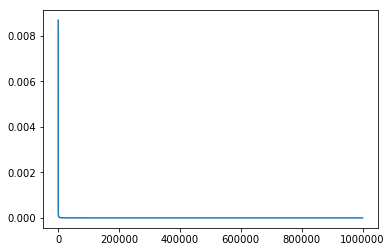

In [81]:
x = np.linspace(10, 1000000, 100000)
y =  reciprocal.pdf(x, a=10, b=1000000)
plt.plot(x, y)

In [82]:
model = SVR()

In [83]:
params = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(a=10, b=1000000),
    'gamma': expon(scale=1.0)
}

In [84]:
random_search = RandomizedSearchCV(
    model,
    params,
    cv=3,
    scoring='neg_mean_squared_error',
    n_iter=5,
    return_train_score=False,
    verbose=2)

In [85]:
random_search.fit(housing_prepared, housing_labels)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] C=9866.336588566946, gamma=0.891678982526602, kernel=linear .....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=9866.336588566946, gamma=0.891678982526602, kernel=linear, total=   7.7s
[CV] C=9866.336588566946, gamma=0.891678982526602, kernel=linear .....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV]  C=9866.336588566946, gamma=0.891678982526602, kernel=linear, total=   8.1s
[CV] C=9866.336588566946, gamma=0.891678982526602, kernel=linear .....
[CV]  C=9866.336588566946, gamma=0.891678982526602, kernel=linear, total=   7.4s
[CV] C=74309.61435621307, gamma=1.2763760166977702, kernel=rbf .......
[CV]  C=74309.61435621307, gamma=1.2763760166977702, kernel=rbf, total=  25.6s
[CV] C=74309.61435621307, gamma=1.2763760166977702, kernel=rbf .......
[CV]  C=74309.61435621307, gamma=1.2763760166977702, kernel=rbf, total=  27.5s
[CV] C=74309.61435621307, gamma=1.2763760166977702, kernel=rbf .......
[CV]  C=74309.61435621307, gamma=1.2763760166977702, kernel=rbf, total=  26.9s
[CV] C=19639.966597154013, gamma=1.559388897764821, kernel=linear ....
[CV]  C=19639.966597154013, gamma=1.559388897764821, kernel=linear, total=   9.3s
[CV] C=19639.966597154013, gamma=1.559388897764821, kernel=linear ....
[CV]  C=19639.966597154013, gamma=1.559388897764821, kernel=linear, total=   9.9s
[CV] C=1963

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  3.1min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'kernel': ['linear', 'rbf'], 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AFAC1D26D8>, 'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001AFAD46E208>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=False, scoring='neg_mean_squared_error',
          verbose=2)

In [86]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

70363.81272544953 {'C': 9866.336588566946, 'gamma': 0.891678982526602, 'kernel': 'linear'}
64969.64205053191 {'C': 74309.61435621307, 'gamma': 1.2763760166977702, 'kernel': 'rbf'}
70354.96646378985 {'C': 19639.966597154013, 'gamma': 1.559388897764821, 'kernel': 'linear'}
103025.2541852378 {'C': 179.3537763091342, 'gamma': 0.30893993941449144, 'kernel': 'rbf'}
118610.42040746527 {'C': 48.20697999471485, 'gamma': 2.2849637585544764, 'kernel': 'rbf'}


In [87]:
random_search.best_params_

{'C': 74309.61435621307, 'gamma': 1.2763760166977702, 'kernel': 'rbf'}

In [88]:
random_searchrch.best_estimator_

SVR(C=74309.61435621307, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=1.2763760166977702, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

## Ex. 3

In [44]:
def indices_of_top_k(feature_importances, k):
    return np.argpartition(feature_importances, -k)[-k:]

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return X[:, self.feature_indices_]

In [45]:
rfr = RandomForestRegressor()
rfr.fit(housing_prepared, housing_labels)

C:\Users\sk8re\Miniconda3\envs\datascience\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [110]:
feature_importances = rfr.feature_importances_
feature_importances

array([5.82659867e-02, 5.74410310e-02, 4.33492473e-02, 1.45763762e-02,
       1.18902048e-02, 1.18155910e-02, 1.04745861e-02, 4.75737755e-01,
       2.73145525e-02, 1.22949336e-01, 2.29678355e-02, 1.27390201e-03,
       1.38960893e-01, 2.02302939e-05, 8.89897733e-04, 2.07257453e-03])

In [47]:
k = 5

In [111]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)

In [49]:
top_k_feature_indices

array([ 1,  0, 12,  9,  7], dtype=int64)

In [112]:
np.array(final_attribs)[top_k_feature_indices]

array(['latitude', 'longitude', 'INLAND', 'pop_per_hhold',
       'median_income'], dtype='<U18')

In [113]:
sorted(zip(feature_importances, final_attribs), reverse=True)[:k]

[(0.47573775548988123, 'median_income'),
 (0.13896089288802452, 'INLAND'),
 (0.12294933601695927, 'pop_per_hhold'),
 (0.058265986707554805, 'longitude'),
 (0.05744103098445778, 'latitude')]

In [71]:
prep_feat_select_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feat_selector', FeatureSelector(fi, k))])

In [72]:
housing_prep_top_k = prep_feat_select_pipeline.fit_transform(housing)

In [76]:
housing_prep_top_k[:3]

array([[ 0.77194962, -1.15604281,  0.        , -0.08649871, -0.61493744],
       [ 0.6596948 , -1.17602483,  0.        , -0.03353391,  1.33645936],
       [-1.34218285,  1.18684903,  0.        , -0.09240499, -0.5320456 ]])

In [80]:
housing_prepared[:3, top_k_feature_indices]

array([[ 0.77194962, -1.15604281,  0.        , -0.08649871, -0.61493744],
       [ 0.6596948 , -1.17602483,  0.        , -0.03353391,  1.33645936],
       [-1.34218285,  1.18684903,  0.        , -0.09240499, -0.5320456 ]])

## Ex. 4

In [117]:
prep_select_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feat_selector', FeatureSelector(feature_importances, k)),
    ('svr', random_search.best_estimator_)
])

In [91]:
prep_select_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos...  gamma=1.2763760166977702, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [108]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

preds = prep_select_predict_pipeline.predict(some_data)

print("labels      predictions")
for y, yhat in zip(some_labels, preds):
    print("{0:8.1f}    {1:8.1f}".format(y, yhat))

labels      predictions
286600.0    206499.7
340600.0    364088.5
196900.0    183001.2
 46300.0     48940.3
254500.0    212553.4


## Ex. 5

In [127]:
prep_select_predict_pipeline.named_steps

{'preparation': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
          transformer_weights=None,
          transformers=[('num', Pipeline(memory=None,
      steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
        strategy='median', verbose=0)), ('feats_adder', CombinedAttributesAdder(add_bedrooms_per_room=True)), ('std_scaler', StandardScaler(copy=True, with_mean=True, with... 'numpy.float64'>, handle_unknown='error',
        n_values=None, sparse=True), ['ocean_proximity'])]),
 'feat_selector': FeatureSelector(feature_importances=array([5.82660e-02, 5.74410e-02, 4.33492e-02, 1.45764e-02, 1.18902e-02,
        1.18156e-02, 1.04746e-02, 4.75738e-01, 2.73146e-02, 1.22949e-01,
        2.29678e-02, 1.27390e-03, 1.38961e-01, 2.02303e-05, 8.89898e-04,
        2.07257e-03]),
         k=5),
 'svr': SVR(C=74309.61435621307, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
   gamma=1.2763760166977702, kernel='rbf', max_iter=-1, shrinking

In [124]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feat_selector__k': list(range(1, len(feature_importances) + 1))
}]

In [125]:
grid_search = GridSearchCV(
    prep_select_predict_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=2)

In [126]:
grid_search.fit(housing, housing_labels)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] feat_selector__k=1, preparation__num__imputer__strategy=mean ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feat_selector__k=1, preparation__num__imputer__strategy=mean, total=   6.2s
[CV] feat_selector__k=1, preparation__num__imputer__strategy=mean ....


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.3s remaining:    0.0s


[CV]  feat_selector__k=1, preparation__num__imputer__strategy=mean, total=   6.1s
[CV] feat_selector__k=1, preparation__num__imputer__strategy=mean ....
[CV]  feat_selector__k=1, preparation__num__imputer__strategy=mean, total=   6.0s
[CV] feat_selector__k=1, preparation__num__imputer__strategy=median ..
[CV]  feat_selector__k=1, preparation__num__imputer__strategy=median, total=   6.1s
[CV] feat_selector__k=1, preparation__num__imputer__strategy=median ..
[CV]  feat_selector__k=1, preparation__num__imputer__strategy=median, total=   6.0s
[CV] feat_selector__k=1, preparation__num__imputer__strategy=median ..
[CV]  feat_selector__k=1, preparation__num__imputer__strategy=median, total=   6.0s
[CV] feat_selector__k=1, preparation__num__imputer__strategy=most_frequent 
[CV]  feat_selector__k=1, preparation__num__imputer__strategy=most_frequent, total=   6.2s
[CV] feat_selector__k=1, preparation__num__imputer__strategy=most_frequent 
[CV]  feat_selector__k=1, preparation__num__imputer__stra

[CV]  feat_selector__k=6, preparation__num__imputer__strategy=most_frequent, total=   9.0s
[CV] feat_selector__k=7, preparation__num__imputer__strategy=mean ....
[CV]  feat_selector__k=7, preparation__num__imputer__strategy=mean, total=  11.5s
[CV] feat_selector__k=7, preparation__num__imputer__strategy=mean ....
[CV]  feat_selector__k=7, preparation__num__imputer__strategy=mean, total=  10.6s
[CV] feat_selector__k=7, preparation__num__imputer__strategy=mean ....
[CV]  feat_selector__k=7, preparation__num__imputer__strategy=mean, total=  11.0s
[CV] feat_selector__k=7, preparation__num__imputer__strategy=median ..
[CV]  feat_selector__k=7, preparation__num__imputer__strategy=median, total=  11.1s
[CV] feat_selector__k=7, preparation__num__imputer__strategy=median ..
[CV]  feat_selector__k=7, preparation__num__imputer__strategy=median, total=  10.6s
[CV] feat_selector__k=7, preparation__num__imputer__strategy=median ..
[CV]  feat_selector__k=7, preparation__num__imputer__strategy=median,

[CV]  feat_selector__k=12, preparation__num__imputer__strategy=most_frequent, total=  23.4s
[CV] feat_selector__k=12, preparation__num__imputer__strategy=most_frequent 
[CV]  feat_selector__k=12, preparation__num__imputer__strategy=most_frequent, total=  25.5s
[CV] feat_selector__k=12, preparation__num__imputer__strategy=most_frequent 
[CV]  feat_selector__k=12, preparation__num__imputer__strategy=most_frequent, total=  23.7s
[CV] feat_selector__k=13, preparation__num__imputer__strategy=mean ...
[CV]  feat_selector__k=13, preparation__num__imputer__strategy=mean, total=  25.6s
[CV] feat_selector__k=13, preparation__num__imputer__strategy=mean ...
[CV]  feat_selector__k=13, preparation__num__imputer__strategy=mean, total=  24.7s
[CV] feat_selector__k=13, preparation__num__imputer__strategy=mean ...
[CV]  feat_selector__k=13, preparation__num__imputer__strategy=mean, total=  24.0s
[CV] feat_selector__k=13, preparation__num__imputer__strategy=median .
[CV]  feat_selector__k=13, preparatio

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 45.0min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbos...  gamma=1.2763760166977702, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'], 'feat_selector__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [129]:
grid_search.best_params_

{'feat_selector__k': 7, 'preparation__num__imputer__strategy': 'mean'}

In [130]:
grid_search.best_estimator_

Pipeline(memory=None,
     steps=[('preparation', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan, strategy='mean',
       verbose=...  gamma=1.2763760166977702, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [131]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

84840.09257059252 {'feat_selector__k': 1, 'preparation__num__imputer__strategy': 'mean'}
84840.09257059252 {'feat_selector__k': 1, 'preparation__num__imputer__strategy': 'median'}
84840.09257059252 {'feat_selector__k': 1, 'preparation__num__imputer__strategy': 'most_frequent'}
75783.52933974986 {'feat_selector__k': 2, 'preparation__num__imputer__strategy': 'mean'}
75783.52933974986 {'feat_selector__k': 2, 'preparation__num__imputer__strategy': 'median'}
75783.52933974986 {'feat_selector__k': 2, 'preparation__num__imputer__strategy': 'most_frequent'}
67045.72657961122 {'feat_selector__k': 3, 'preparation__num__imputer__strategy': 'mean'}
67045.72657961122 {'feat_selector__k': 3, 'preparation__num__imputer__strategy': 'median'}
67045.72657961122 {'feat_selector__k': 3, 'preparation__num__imputer__strategy': 'most_frequent'}
63126.73864706994 {'feat_selector__k': 4, 'preparation__num__imputer__strategy': 'mean'}
63126.73864706994 {'feat_selector__k': 4, 'preparation__num__imputer__strateg

Apparently, k = 7 gives the best result, but we didn't really start with a good model. We should probably find a better model and redo this analysis.